In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from functools import partial
import warnings

# Suppress warnings from root finding when a bound state doesn't exist
warnings.filterwarnings('ignore', 'b_less_than_a', UserWarning)

# --- 1. Single-Particle Properties (Vectorized) ---

def H0(k, phi):
    """Vectorized single-particle momentum-space Hamiltonian H(k)."""
    k = np.atleast_1d(k)
    H = np.zeros((k.shape[0], 3, 3), dtype=complex)
    h12 = np.exp(1j * phi) + np.exp(1j * k)
    h13 = 1 + np.exp(1j * k)
    H[:, 0, 1] = h12
    H[:, 1, 0] = np.conj(h12)
    H[:, 0, 2] = h13
    H[:, 2, 0] = np.conj(h13)
    return H[0] if H.shape[0] == 1 else H

def get_single_particle_bands(k_values, phi):
    """Calculate the 3 single-particle energy bands."""
    energies = np.linalg.eigvalsh(H0(k_values, phi))
    return energies.T

def get_continuum_bounds(K, phi, num_q=101):
    """Calculate the two-particle scattering continuum bounds for a given K."""
    q_values = np.linspace(-np.pi, np.pi, num_q)
    k1 = K/2 + q_values
    k2 = K/2 - q_values
    eigs1 = np.linalg.eigvalsh(H0(k1, phi))
    eigs2 = np.linalg.eigvalsh(H0(k2, phi))
    continuum_energies = (eigs1[:, :, np.newaxis] + eigs2[:, np.newaxis, :]).flatten()
    return np.min(continuum_energies), np.max(continuum_energies)

# --- 2. Two-Particle Formalism (Unchanged) ---

def get_real_space_matrices(phi):
    H_intra = np.array([[0, np.exp(1j*phi), 1], [np.exp(-1j*phi), 0, 0], [1, 0, 0]], dtype=complex)
    H_inter = np.array([[0, 1, 1], [0, 0, 0], [0, 0, 0]], dtype=complex)
    H_inter_minus = H_inter.T.conj()
    return H_intra, H_inter, H_inter_minus

def get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus):
    """
    Constructs the effective 9x9 hopping matrices for the relative coordinate.
    This version is based on the definitive derivation using r = pos_1 - pos_2.
    """
    I = np.eye(3, dtype=complex)
    
    # --- T0: Hopping within the same relative coordinate 'r' ---
    # This represents H(r,r) in the Schrodinger equation.
    # It is derived from H_kin = (H_1+H_2) = (H_intra ⊗ I) + (I ⊗ H_intra).
    T0 = np.kron(H_intra, I) + np.kron(I, H_intra)

    # --- T_plus_1: Hopping that increases r by 1 (e.g., r-1 -> r) ---
    # This is the matrix H(r, r-1) that multiplies psi(r-1).
    # It corresponds to a term exp(+ik) in the Fourier domain.
    # Caused by: (p1 hops forward) OR (p2 hops backward).
    T_plus_1 = (np.kron(H_inter, I) * np.exp(1j*K/2)) + \
               (np.kron(I, H_inter_minus) * np.exp(-1j*K/2))

    # --- T_minus_1: Hopping that decreases r by 1 (e.g., r+1 -> r) ---
    # This is the matrix H(r, r+1) that multiplies psi(r+1).
    # It corresponds to a term exp(-ik) in the Fourier domain.
    # Caused by: (p1 hops backward) OR (p2 hops forward).
    T_minus_1 = (np.kron(H_inter_minus, I) * np.exp(-1j*K/2)) + \
                (np.kron(I, H_inter) * np.exp(1j*K/2))

    # The Green's function calculation uses the Fourier transformed kinetic Hamiltonian:
    # H_kin(K,q) = T0 + T_plus_1 * exp(iq) + T_minus_1 * exp(-iq)
    # The returned matrices correspond to these terms.
    return T0, T_plus_1, T_minus_1

# --- 3. Green's Function and Root Finding for Multiple Bands ---

def calculate_G00(E, T0, T1, T_minus_1, num_q=201):
    """Calculates the on-site (r=0) Green's function matrix G(0,0)."""
    q_values = np.linspace(-np.pi, np.pi, num_q)
    G00 = np.zeros((9, 9), dtype=complex)
    I9 = np.eye(9)
    for q in q_values:
        #some sort of plan wave ansatz
        H_kin_K_q = T0 + T1 * np.exp(1j*q) + T_minus_1 * np.exp(-1j*q)
        try:
            #the resolvent
            G00 += np.linalg.inv(E * I9 - H_kin_K_q)
        except np.linalg.LinAlgError:
            return np.full((9, 9), np.inf)
    return G00 / num_q

# ****************** NEW ROOT EQUATION FOR MULTIPLE BANDS ******************
def eigenvalue_root_equation(E, U, T0, T1, T_minus_1, eigenvalue_index):
    """
    Root function based on the eigenvalue condition: lambda_i(E) - 1/U = 0.
    """
    if np.isinf(E) or np.isnan(E) or U == 0:
        return np.inf

    G00 = calculate_G00(E, T0, T1, T_minus_1)
    if np.any(np.isinf(G00)):
        return np.inf
        
    interacting_indices = [0, 4, 8]
    G_reduced = G00[np.ix_(interacting_indices, interacting_indices)]

    try:
        # We use eigvalsh because G_reduced should be Hermitian
        lambdas = np.linalg.eigvalsh(G_reduced)
        # Sort eigenvalues to have a consistent index
        lambdas = np.sort(lambdas)
        
        # The equation to solve
        return lambdas[eigenvalue_index] - (1.0 / U)
        
    except np.linalg.LinAlgError:
        return np.inf
# **************************************************************************

Calculating continuum...
Searching for bound state bands...
--- Searching for band #1 ---
--- Searching for band #2 ---
--- Searching for band #3 ---
Plotting results. Found 3 bound state band(s).


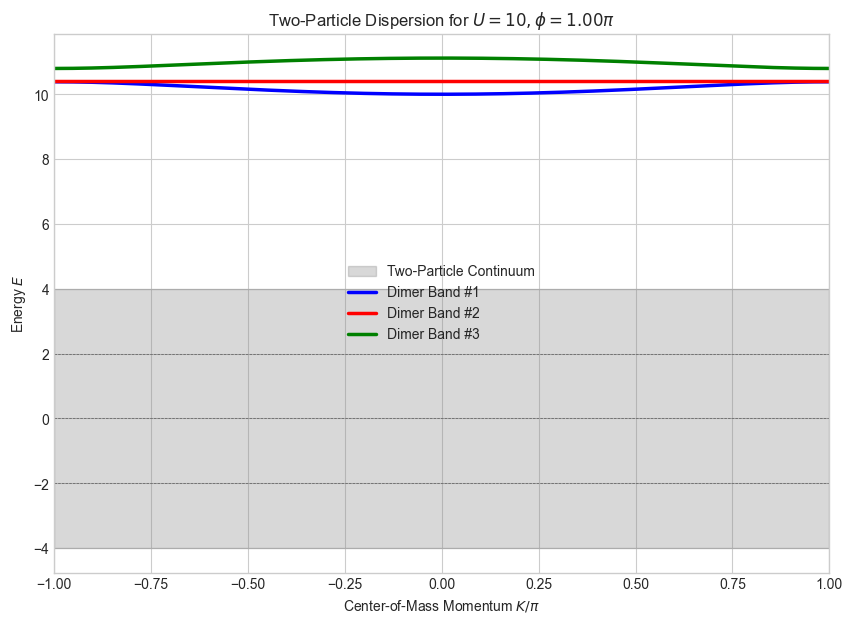

In [3]:

# --- Parameters ---
U = 10  # Interaction strength. Larger |U| often reveals more bands.
phi = np.pi
N_K = 251 # Number of COM momentum points

#K_values = np.linspace(-np.pi, np.pi, N_K)
K_values = np.linspace(-np.pi, np.pi, N_K)

# We now need a place to store multiple bands
all_bound_state_bands = []
num_bands_to_find = 3

# --- Pre-calculate real-space matrices ---
H_intra, H_inter, H_inter_minus = get_real_space_matrices(phi)

print("Calculating continuum...")
continuum_min = np.zeros(N_K)
continuum_max = np.zeros(N_K)
for i, K in enumerate(K_values):
    continuum_min[i], continuum_max[i] = get_continuum_bounds(K, phi)

print("Searching for bound state bands...")
# Loop over each potential band
for band_idx in range(num_bands_to_find):
    print(f"--- Searching for band #{band_idx + 1} ---")
    current_band_energies = np.full(N_K, np.nan)
    
    # Loop over each K point
    for i, K in enumerate(K_values):
        # Get effective matrices for this K
        T0, T1, T_minus_1 = get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus)
        
        # Define search range. Widen it slightly to catch all bands.
        if U < 0:
            search_min = continuum_min[i] - 4 * abs(U)
            search_max = continuum_min[i] - 1e-6
        else:
            search_min = continuum_max[i] + 1e-6
            search_max = continuum_max[i] + 4 * abs(U)

        # ******************** FIX IS HERE ********************
        # Use the correct keyword argument 'T_minus_1'
        f_to_solve = partial(eigenvalue_root_equation, U=U, T0=T0, T1=T1, T_minus_1=T_minus_1,
                                eigenvalue_index=band_idx)
        # *****************************************************
        
        try:
            # The bracket might fail if the function doesn't cross zero.
            # We check the signs at the boundaries.
            val_min = f_to_solve(search_min)
            val_max = f_to_solve(search_max)
            if np.isfinite(val_min) and np.isfinite(val_max) and np.sign(val_min) != np.sign(val_max):
                sol = root_scalar(f_to_solve, bracket=[search_min, search_max], method='brentq')
                if sol.converged:
                    current_band_energies[i] = sol.root
        except (ValueError, RuntimeError):
                # This can happen if the root is not in the bracket or other issues.
                pass
    
    # Only add the band if we actually found any energies for it
    if not np.all(np.isnan(current_band_energies)):
        all_bound_state_bands.append(current_band_energies)

# --- Plotting ---
print(f"Plotting results. Found {len(all_bound_state_bands)} bound state band(s).")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the continuum
ax.fill_between(K_values / np.pi, continuum_min, continuum_max, 
                color='gray', alpha=0.3, label='Two-Particle Continuum')

# Plot the single-particle bands for reference
k_plot = np.linspace(-np.pi, np.pi, 201)
sp_bands = get_single_particle_bands(k_plot, phi)
for band in sp_bands:
    ax.plot(k_plot / np.pi, band, 'k--', linewidth=0.5, alpha=0.5, label='_nolegend_')
    
# Plot all the found bound state bands
colors = ['blue', 'red', 'green']
for i, band_energies in enumerate(all_bound_state_bands):
    ax.plot(K_values / np.pi, band_energies, '-', color=colors[i % len(colors)],
            linewidth=2.5, label=f'Dimer Band #{i+1}')

ax.set_xlabel(r'Center-of-Mass Momentum $K/\pi$')
ax.set_ylabel('Energy $E$')
ax.set_title(fr'Two-Particle Dispersion for $U={U}, \phi={phi/np.pi:.2f}\pi$')
ax.legend()
ax.set_xlim(-1, 1)

#plt.savefig(f"{U}U0phibands.pdf")
plt.show()



Calculating continuum...
Searching for bound state bands...
--- Searching for band #1 ---
--- Searching for band #2 ---
--- Searching for band #3 ---
Plotting results. Found 3 bound state band(s).


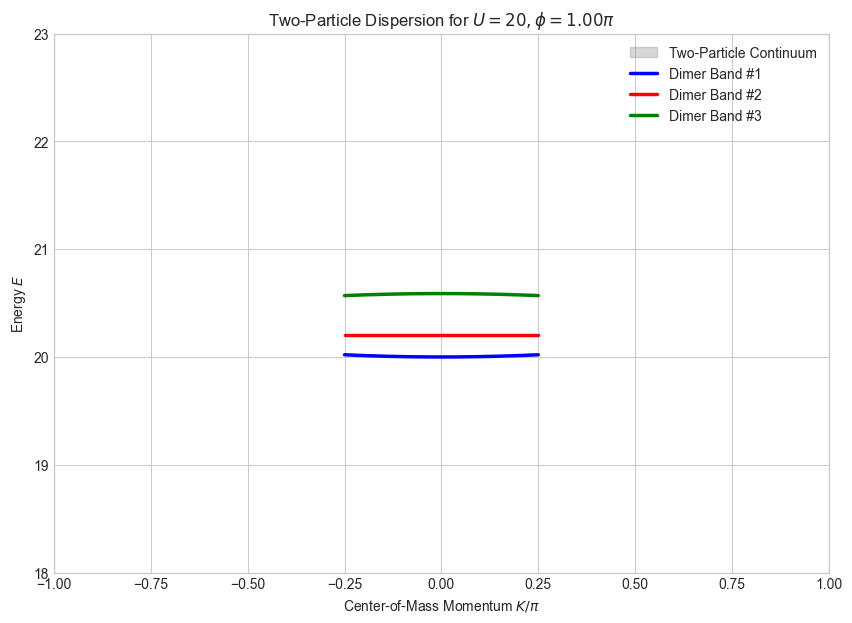

In [8]:

# --- Parameters ---
U = 20  # Interaction strength. Larger |U| often reveals more bands.
phi = np.pi
N_K = 251 # Number of COM momentum points

#K_values = np.linspace(-np.pi, np.pi, N_K)
K_values = np.linspace(-np.pi/4, np.pi/4, N_K)

# We now need a place to store multiple bands
all_bound_state_bands = []
num_bands_to_find = 3

# --- Pre-calculate real-space matrices ---
H_intra, H_inter, H_inter_minus = get_real_space_matrices(phi)

print("Calculating continuum...")
continuum_min = np.zeros(N_K)
continuum_max = np.zeros(N_K)
for i, K in enumerate(K_values):
    continuum_min[i], continuum_max[i] = get_continuum_bounds(K, phi)

print("Searching for bound state bands...")
# Loop over each potential band
for band_idx in range(num_bands_to_find):
    print(f"--- Searching for band #{band_idx + 1} ---")
    current_band_energies = np.full(N_K, np.nan)
    
    # Loop over each K point
    for i, K in enumerate(K_values):
        # Get effective matrices for this K
        T0, T1, T_minus_1 = get_T_eff_matrices(K, H_intra, H_inter, H_inter_minus)
        
        # Define search range. Widen it slightly to catch all bands.
        if U < 0:
            search_min = continuum_min[i] - 4 * abs(U)
            search_max = continuum_min[i] - 1e-6
        else:
            search_min = continuum_max[i] + 1e-6
            search_max = continuum_max[i] + 4 * abs(U)

        # ******************** FIX IS HERE ********************
        # Use the correct keyword argument 'T_minus_1'
        f_to_solve = partial(eigenvalue_root_equation, U=U, T0=T0, T1=T1, T_minus_1=T_minus_1,
                                eigenvalue_index=band_idx)
        # *****************************************************
        
        try:
            # The bracket might fail if the function doesn't cross zero.
            # We check the signs at the boundaries.
            val_min = f_to_solve(search_min)
            val_max = f_to_solve(search_max)
            if np.isfinite(val_min) and np.isfinite(val_max) and np.sign(val_min) != np.sign(val_max):
                sol = root_scalar(f_to_solve, bracket=[search_min, search_max], method='brentq')
                if sol.converged:
                    current_band_energies[i] = sol.root
        except (ValueError, RuntimeError):
                # This can happen if the root is not in the bracket or other issues.
                pass
    
    # Only add the band if we actually found any energies for it
    if not np.all(np.isnan(current_band_energies)):
        all_bound_state_bands.append(current_band_energies)

# --- Plotting ---
print(f"Plotting results. Found {len(all_bound_state_bands)} bound state band(s).")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the continuum
ax.fill_between(K_values / np.pi, continuum_min, continuum_max, 
                color='gray', alpha=0.3, label='Two-Particle Continuum')

# Plot the single-particle bands for reference
k_plot = np.linspace(-np.pi, np.pi, 201)
sp_bands = get_single_particle_bands(k_plot, phi)
for band in sp_bands:
    ax.plot(k_plot / np.pi, band, 'k--', linewidth=0.5, alpha=0.5, label='_nolegend_')
    
# Plot all the found bound state bands
colors = ['blue', 'red', 'green']
for i, band_energies in enumerate(all_bound_state_bands):
    ax.plot(K_values / np.pi, band_energies, '-', color=colors[i % len(colors)],
            linewidth=2.5, label=f'Dimer Band #{i+1}')

ax.set_xlabel(r'Center-of-Mass Momentum $K/\pi$')
ax.set_ylabel('Energy $E$')
ax.set_title(fr'Two-Particle Dispersion for $U={U}, \phi={phi/np.pi:.2f}\pi$')
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(18,23)
#plt.savefig(f"{U}U0phibands.pdf")
plt.show()



In [14]:
all_bound_state_bands[0]

array([20.02037888, 20.02006027, 20.01974403, 20.01943016, 20.01911865,
       20.01880952, 20.01850277, 20.01819841, 20.01789643, 20.01759685,
       20.01729967, 20.01700489, 20.01671252, 20.01642256, 20.01613502,
       20.01584989, 20.0155672 , 20.01528693, 20.01500909, 20.0147337 ,
       20.01446074, 20.01419023, 20.01392217, 20.01365657, 20.01339342,
       20.01313274, 20.01287452, 20.01261877, 20.0123655 , 20.0121147 ,
       20.01186639, 20.01162055, 20.01137721, 20.01113636, 20.01089801,
       20.01066215, 20.0104288 , 20.01019795, 20.00996962, 20.00974379,
       20.00952048, 20.0092997 , 20.00908143, 20.00886569, 20.00865249,
       20.00844181, 20.00823367, 20.00802807, 20.00782501, 20.00762449,
       20.00742652, 20.00723111, 20.00703824, 20.00684793, 20.00666019,
       20.006475  , 20.00629238, 20.00611232, 20.00593484, 20.00575992,
       20.00558759, 20.00541783, 20.00525065, 20.00508605, 20.00492404,
       20.00476461, 20.00460777, 20.00445353, 20.00430188, 20.00

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def poly2_poly4_compare(x, y, *, scatter_kwargs=None, line_kwargs=None):
    """
    Fit y = a*x^2 + c and y = a*x^4 + c to (x, y) data and plot the fits
    with residuals.

    Parameters
    ----------
    x, y : 1-dimensional array-like
        Input and output data of equal length.
    scatter_kwargs, line_kwargs : dict, optional
        Extra keyword arguments forwarded to `ax.scatter` and `ax.plot`
        (e.g. marker size, alpha, linestyle).

    Returns
    -------
    (a2, c2), (a4, c4) : tuple of fit parameters
        Best-fit coefficients for the quadratic and quartic models.
    """

    x   = np.asarray(x, dtype=float).ravel()
    y   = np.asarray(y, dtype=float).ravel()
    N   = len(x)
    if len(y) != N:
        raise ValueError("x and y must have the same length")

    # --- helper for linear least-squares with one basis function + constant
    def fit_basis(basis):
        M   = np.vstack([basis, np.ones_like(x)]).T         # design matrix
        coeff, *_ = np.linalg.lstsq(M, y, rcond=None)       # [a, c]
        y_hat   = M @ coeff
        resid   = y - y_hat
        r2      = 1.0 - resid.dot(resid) / np.square(y - y.mean()).sum()
        return coeff, y_hat, resid, r2

    (a2, c2), y2, r2_resid, R2_quad = fit_basis(x**2)
    (a4, c4), y4, r4_resid, R2_quar = fit_basis(x**4)

    # ---------- Plotting ----------
    scatter_kwargs = scatter_kwargs or dict(s=25, alpha=0.8)
    line_kwargs    = line_kwargs    or dict(lw=2)

    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    gs  = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)

    # Quadratic fit (left)
    ax_q = fig.add_subplot(gs[0, 0])
    ax_q.scatter(x, y, label="data", **scatter_kwargs)
    ax_q.plot(np.sort(x), y2[np.argsort(x)], label=f"fit  $R^2={R2_quad:.4f}$", **line_kwargs)
    ax_q.set_title(r"$y = a_2 x^2 + c_2$")
    ax_q.legend()
    ax_q.set_ylabel("y")

    # Quartic fit (right)
    ax_4 = fig.add_subplot(gs[0, 1])
    ax_4.scatter(x, y, label="data", **scatter_kwargs)
    ax_4.plot(np.sort(x), y4[np.argsort(x)], label=f"fit  $R^2={R2_quar:.4f}$", **line_kwargs)
    ax_4.set_title(r"$y = a_4 x^4 + c_4$")
    ax_4.legend()

    # Residuals
    ax_qr = fig.add_subplot(gs[1, 0], sharex=ax_q)
    ax_qr.axhline(0, lw=0.8, color="k")
    ax_qr.scatter(x, r2_resid, **scatter_kwargs)
    ax_qr.set_xlabel("x")
    ax_qr.set_ylabel("residual")

    ax_4r = fig.add_subplot(gs[1, 1], sharex=ax_4)
    ax_4r.axhline(0, lw=0.8, color="k")
    ax_4r.scatter(x, r4_resid, **scatter_kwargs)
    ax_4r.set_xlabel("x")

    plt.show()

    return (a2, c2), (a4, c4)


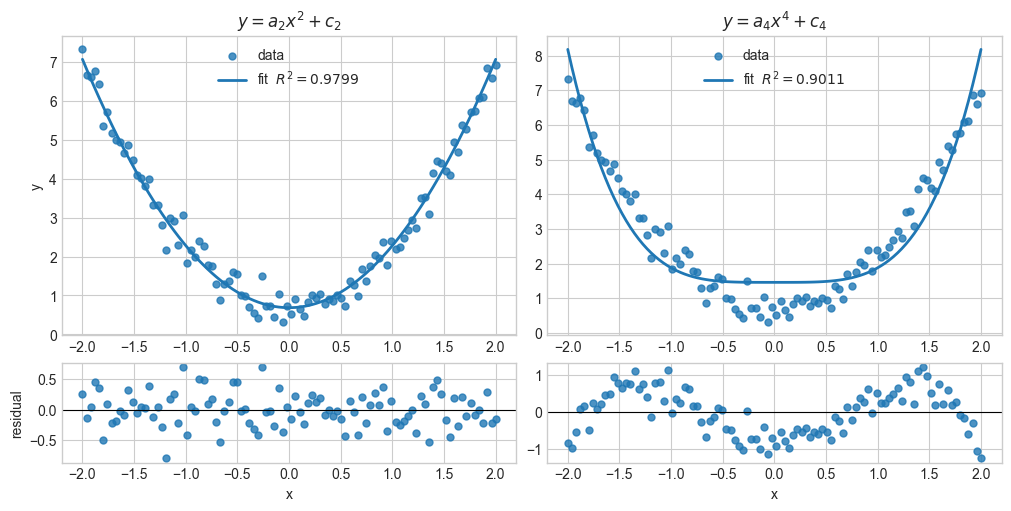

Quadratic  (a2, c2): (np.float64(1.59712496624936), np.float64(0.685826288954145))
Quartic    (a4, c4): (np.float64(0.4197708088678376), np.float64(1.4604446734439642))


In [10]:
# Example usage
np.random.seed(0)
x_data = np.linspace(-2, 2, 100)
y_data = 1.5 * x_data**2 + 0.8 + 0.3*np.random.normal(size=x_data.size)

params_quad, params_quart = poly2_poly4_compare(x_data, y_data)
print("Quadratic  (a2, c2):", params_quad)
print("Quartic    (a4, c4):", params_quart)


In [15]:
len(all_bound_state_bands[0])

251

In [17]:
len(K_values)

251

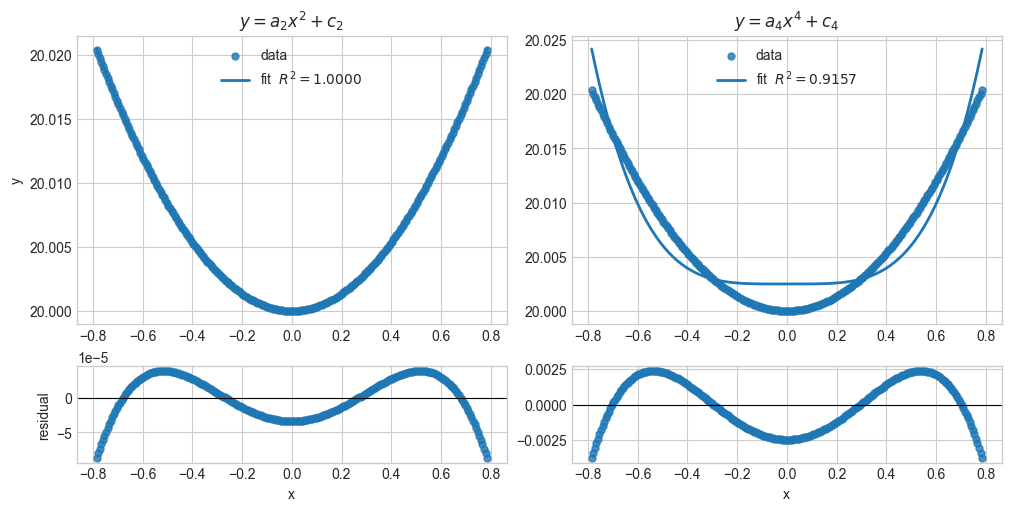

Quadratic  (a2, c2): (np.float64(0.03312355900721228), np.float64(20.000034022339978))
Quartic    (a4, c4): (np.float64(0.05699716099164827), np.float64(20.002492149856394))


In [18]:
params_quad, params_quart = poly2_poly4_compare(K_values,all_bound_state_bands[0])
print("Quadratic  (a2, c2):", params_quad)
print("Quartic    (a4, c4):", params_quart)


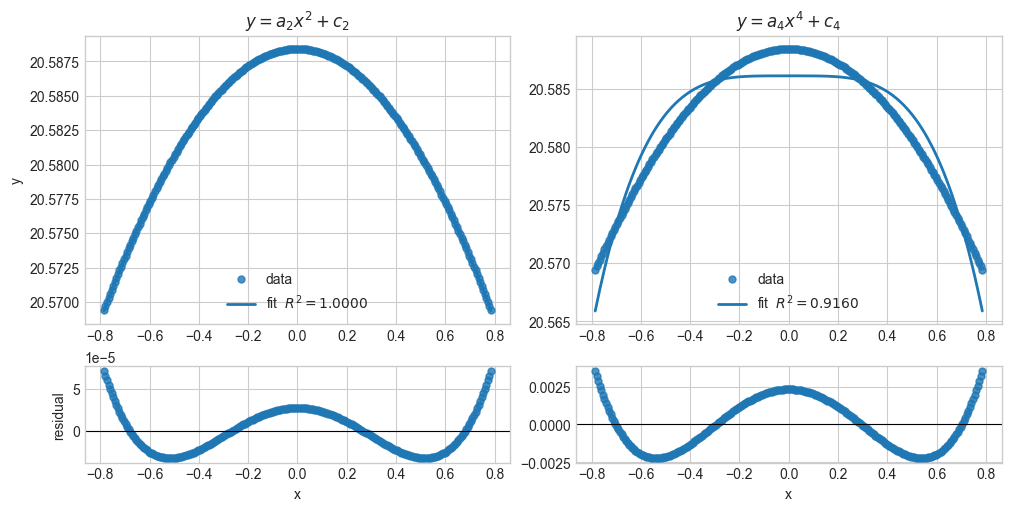

Quadratic  (a2, c2): (np.float64(-0.030854583832856927), np.float64(20.58838409684624))
Quartic    (a4, c4): (np.float64(-0.053102823806073486), np.float64(20.58609512419299))


In [19]:
params_quad, params_quart = poly2_poly4_compare(K_values,all_bound_state_bands[2])
print("Quadratic  (a2, c2):", params_quad)
print("Quartic    (a4, c4):", params_quart)
